In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [3]:
from datetime import datetime, timedelta 
from dateutil.relativedelta import relativedelta

In [4]:
df_orig = pd.read_csv(r'data/merged_data_20190728.csv', parse_dates = ['count_date'])
df = df_orig.copy()
df.sort_values(by = "count_date", inplace = True)
df.head()
df.tail()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
4682,12411.0,40986,COLWILL RD,SPARGO RD,END,1704.0,No,1974-07-12,125.0,-36.832191,174.636777,6.8,"< 10,000 vpd Rural/<15,000 vpd Urban",396.674078
11389,13617.0,40854,GLORIA AVE,OLD TE ATATU RD,GRAHAM AVE,99.0,No,1974-08-11,1823.0,-36.848907,174.650109,11.2,"< 10,000 vpd Rural/<15,000 vpd Urban",113.001344
65,10376.0,40798,HOBSONVILLE RD,LUCKENS RD,WESTPARK DR,1517.0,No,1974-08-11,2163.0,-36.814264,174.630139,9.0,">= 15,000 vpd Urban road, low speed",581.914617
49,10308.0,40798,HOBSONVILLE RD,MOTORWAY OVERBRIDGE (EAST ABUTMENT),OREIL AVE,158.0,No,1974-08-11,3900.0,-36.818091,174.615882,28.0,">= 15,000 vpd Urban road, low speed",199.169213
12333,11261.0,40365,TAIKATA RD,TE ATATU RD RAB,PEACHGROVE RD,30.0,No,1974-08-11,2490.0,-36.841192,174.651345,10.1,"< 10,000 vpd Rural/<15,000 vpd Urban",131.001559


,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
22943,11585.0,40522,POMARIA RD,KINGDALE RD,LONGBURN RD,448.0,Yes,2019-03-06,6994.0,-36.861600,174.623820,8.6,"< 10,000 vpd Rural/<15,000 vpd Urban",185.273683
22964,13123.0,40909,FAIRDENE AVE,STEPHEN AVE,EDWARDS AVE,308.0,Yes,2019-03-06,3089.0,-36.865612,174.626350,7.5,"< 10,000 vpd Rural/<15,000 vpd Urban",337.605067
22942,11330.0,40389,STEPHEN AVE,POMARIA RD,KONA CRES (NORTH),107.0,Yes,2019-03-06,828.0,-36.863331,174.627693,7.0,<500 vpd (Low Volume),196.603260
22945,11747.0,40624,MILDMAY RD,HARRINGTON RD (AT TEE),LARISSA AVE,215.0,Yes,2019-03-06,294.0,-36.861519,174.617166,6.8,<500 vpd (Low Volume),175.769275
22952,12107.0,40823,HARRINGTON RD,HARRY WARD PL,ASCOT AVE,215.0,Yes,2019-03-06,1568.0,-36.859423,174.619489,7.0,"< 10,000 vpd Rural/<15,000 vpd Urban",113.234506


In [5]:
# consider only traffic counts after 2010
df.shape
df = df[df['count_date'] > pd.to_datetime('2009-12-31')].shape

(25741, 14)

(17826, 14)

In [4]:
import re
def add_datepart(df, fldname, drop=False, time=False, errors="raise"):	

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Dayofyear', 'Week', 'Year', 'Month']
#     , , 'Day',''Dayofweek''
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [5]:
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'traff_manage_level', 'Shape__Length'],
      dtype='object')

In [6]:
# encode cat columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name', 
            'location', 'latest', 'traff_manage_level']
label_encoders_dict = {}
for col in cat_cols:
    new_le = LabelEncoder()
    df[col] = new_le.fit_transform(df[col])
    label_encoders_dict[col] = new_le
display_all(df.head())

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
4682,3392,2635,663,3637,1252,1604,0,1974-07-12,125.0,-36.832191,174.636777,6.8,0,396.674078
11389,3672,2585,1167,2762,1701,98,0,1974-08-11,1823.0,-36.848907,174.650109,11.2,0,113.001344
65,2688,2559,1438,2184,4866,1460,0,1974-08-11,2163.0,-36.814264,174.630139,9.0,3,581.914617
49,2677,2559,1438,2545,3193,157,0,1974-08-11,3900.0,-36.818091,174.615882,28.0,3,199.169213
12333,3022,2411,3384,3919,3334,29,0,1974-08-11,2490.0,-36.841192,174.651345,10.1,0,131.001559


In [7]:
# one hot encode traff_manage_level
df = pd.get_dummies(df, prefix_sep = "__", columns = ['traff_manage_level'])
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25741 entries, 4682 to 22952
Data columns (total 21 columns):
carr_way_no              25741 non-null int64
road_id                  25741 non-null int64
road_name                25741 non-null int32
start_name               25741 non-null int32
end_name                 25741 non-null int32
location                 25741 non-null int64
latest                   25741 non-null int32
count_date               25741 non-null datetime64[ns]
adt                      25741 non-null float64
latitude                 25741 non-null float64
longitude                25741 non-null float64
cway_width               25741 non-null float64
Shape__Length            25741 non-null float64
traff_manage_level__0    25741 non-null uint8
traff_manage_level__1    25741 non-null uint8
traff_manage_level__2    25741 non-null uint8
traff_manage_level__3    25741 non-null uint8
traff_manage_level__4    25741 non-null uint8
traff_manage_level__5    25741 non-null u

In [9]:
add_datepart(df, 'count_date')

In [37]:
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

def rmse(x,y): 
    # calculates r^2
    return math.sqrt(np.square(np.subtract(x,y)).mean())
def get_scores(m, X_train, X_valid, y_train, y_valid):
    # returns rmsq training, r^2 validation, avg accuracy training, avg accuracy validation, oob
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    return res

def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test

def tt_split_by_years(df, xcols, ycol, train_years = [2016, 2017, 2018], test_years = [2019]):
#     train-test split by year
    df_train = df[df.count_Year.isin(train_years)]
    df_test = df[df.count_Year.isin(test_years)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 3):
#     walk forward train-test split
    d = pd.to_datetime(split_date)
    train_lb = d - relativedelta(months = train_months)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[(df.count_date >= train_lb)&(df.count_date < d)]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def expanding_window_split(df, xcols, ycol, split_date = '2018-01-01', test_months = 2):
    # expanding window split
    d = pd.to_datetime(split_date)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[df.count_date < d]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [11]:
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7', 'count_Dayofyear', 'count_Week', 'count_Year',
       'count_Month', 'count_Elapsed'],
      dtype='object')

In [12]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
xcols.remove('count_date')
xcols.remove('latest')
ycol = 'adt'

In [14]:
# expanding_window_split performs better than sliding window
# X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 2)
# m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = 3)
# m.fit(X_train, y_train)
# m.score(X_train, y_train)
# m.score(X_test, y_test)
# m.oob_score_
# rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9923116865122593

0.8954008714993777

0.9442739970849913

,cols,imp
11,traff_manage_level__2,0.258170
7,cway_width,0.210416
1,road_id,0.094472
12,traff_manage_level__3,0.074829
4,location,0.058666
0,carr_way_no,0.054107
17,count_Dayofyear,0.043928
9,traff_manage_level__0,0.034260
5,latitude,0.034076
6,longitude,0.031145


In [38]:
X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = '2018-12-31', test_months = 3)
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = 3)
m.fit(X_train, y_train)
m.score(X_train, y_train)
m.score(X_test, y_test)
m.oob_score_
rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9963457471940269

0.9245895165945502

0.9731371093761076

,cols,imp
11,traff_manage_level__2,0.267206
7,cway_width,0.202535
1,road_id,0.136687
4,location,0.062858
0,carr_way_no,0.059122
17,count_Dayofyear,0.034156
5,latitude,0.033766
6,longitude,0.031514
12,traff_manage_level__3,0.030953
21,count_Elapsed,0.027337


Got a much better results once road info are added into the model

In [50]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = 3)
def get_list_of_split_dates(df, start_date = '2017-01-01', test_months = 2):
    d = pd.to_datetime(start_date)
    last_date = df.count_date.max()
    test_ub = d + relativedelta(months = test_months)
    list_of_split_dates = [d]
    while test_ub < last_date:  
        list_of_split_dates.append(test_ub)
        test_ub += relativedelta(months = test_months)
    return list_of_split_dates

def back_testing(df, xcols, ycol, start_date = '2017-01-01', test_months = 2):
    list_of_split_dates = get_list_of_split_dates(df, start_date = start_date, test_months = test_months)
    results = []
    for split_date in list_of_split_dates:
        X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = split_date, test_months = test_months)
        m.fit(X_train, y_train)
        r = get_scores(m, X_train, X_test, y_train, y_test)
        results.append(r)
    return np.vstack(results)
results = back_testing(df, xcols, ycol, start_date = '2017-01-01', test_months = 2)

In [51]:
results  # rmse_train rmse_test, r2_train, r2_test, oob

array([[9.83803246e+02, 2.06490253e+03, 9.96628975e-01, 9.42686603e-01,
        9.75128214e-01],
       [9.80913640e+02, 2.92067132e+03, 9.96620110e-01, 9.03194961e-01,
        9.75007118e-01],
       [9.75027637e+02, 3.78057636e+03, 9.96627398e-01, 8.69176221e-01,
        9.75082332e-01],
       [9.74889766e+02, 2.37592819e+03, 9.96597465e-01, 9.12244749e-01,
        9.74924210e-01],
       [9.65749870e+02, 2.88127254e+03, 9.96620120e-01, 8.87621694e-01,
        9.75051961e-01],
       [9.68766747e+02, 3.01610182e+03, 9.96561272e-01, 8.75800134e-01,
        9.74648933e-01],
       [9.73543031e+02, 2.27637101e+03, 9.96485755e-01, 9.02933538e-01,
        9.74158480e-01],
       [9.70341750e+02, 2.98669307e+03, 9.96475548e-01, 8.38558448e-01,
        9.74033866e-01],
       [9.57640711e+02, 4.28165771e+03, 9.96517568e-01, 7.84113295e-01,
        9.74409170e-01],
       [9.62660817e+02, 2.67923086e+03, 9.96424978e-01, 8.90902989e-01,
        9.73754921e-01],
       [9.68039023e+02, 3.1017

In [53]:
results.mean(axis = 0)

array([9.69318023e+02, 2.77280685e+03, 9.96491449e-01, 8.69175963e-01,
       9.74177537e-01])

In [59]:
from pdpbox import pdp, info_plots

In [62]:
xcols2 = xcols.copy()
xcols2.remove('count_Elapsed')
# train on the full dataset
m.fit(df[xcols2], df[ycol])
m.oob_score_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9738482191902247

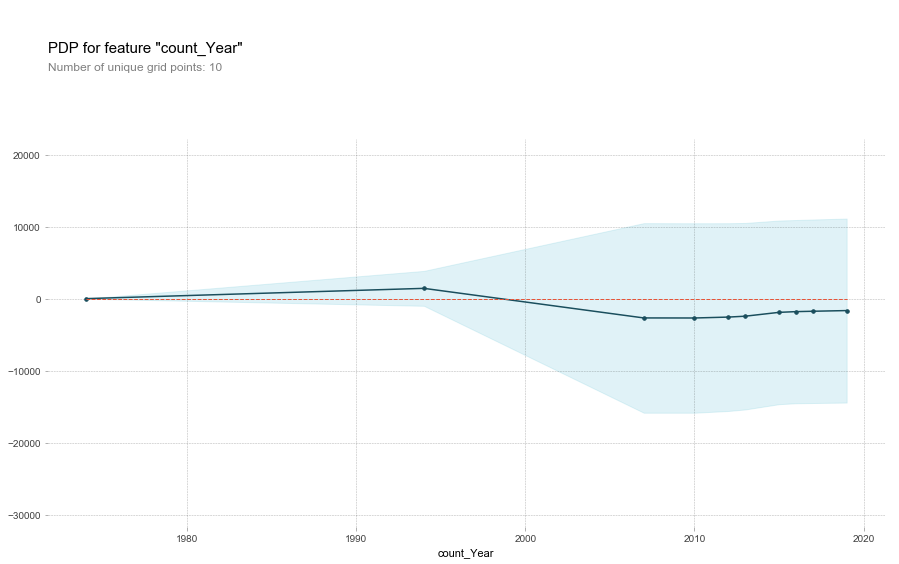

In [63]:
pdp_year = pdp.pdp_isolate(
    model=m, dataset=df[xcols2], model_features=xcols2, feature='count_Year'
)
fig, axes = pdp.pdp_plot(pdp_year, 'count_Year')

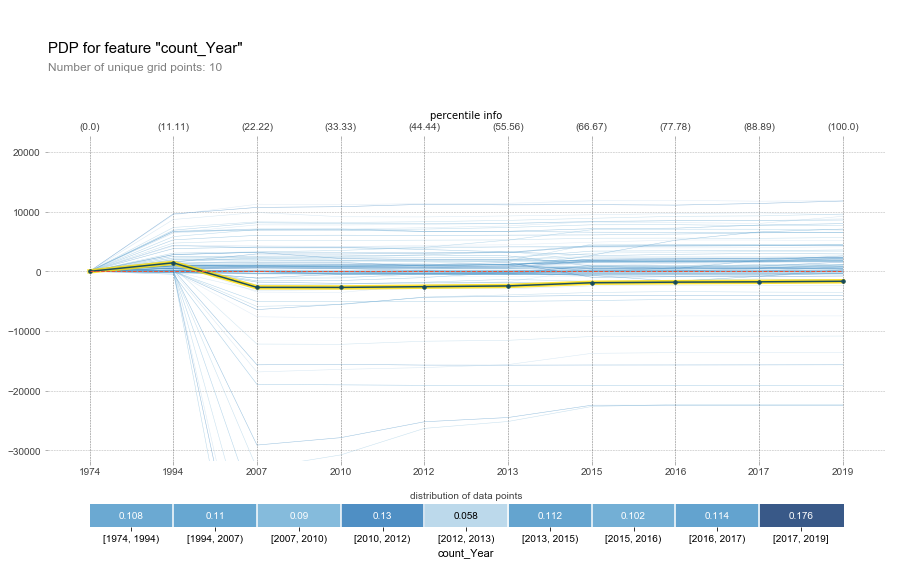

In [66]:
fig, axes = pdp.pdp_plot(
    pdp_year, 'count_Year', plot_lines=True, frac_to_plot=100, x_quantile=True, 
    plot_pts_dist=True, show_percentile=True
)